# Explore and Format CAFA 5 training set

In this notebook we explore the species aspect of the CAFA5 training data and transform it into a Huggingface dataset

## Imports

In [24]:
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sb
from datasets import Dataset
import os

## Helper functions

In [7]:
def get_species(desc):
    try:
        items = desc.split("=")
        assert items[0][-2:]=="OS"
        return items[1].strip(" OX").split("(")[0]
    except:
        return "no species info"

In [8]:
def get_PE(desc):
    try:
        items = desc.split("=")
        assert items[3][-2:]=="PE"
        return items[4].strip(" SV").split("(")[0]
    except:
        return "no PE info"

## Collect data from Fasta file descriptions

In [25]:
data_path = os.path.join("data", "CAFA5", "Train", "train_sequences.fasta")

absolute_path = os.path.abspath(data_path)

print(absolute_path)


C:\Users\49176\Unistuff\PP2\data\CAFA5\Train\train_sequences.fasta


In [26]:
with open(data_path) as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    species=[]
    PE=[]
    seqs=[]
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        lengths.append(len(seq_record.seq))
        seqs.append(str(seq_record.seq))
        species.append(get_species(seq_record.description))
        PE.append(get_PE(seq_record.description))

FileNotFoundError: [Errno 2] No such file or directory: 'data\\CAFA5\\Train\\train_sequences.fasta'

### Check size of dataset

In [8]:
len(identifiers)

142246

In [10]:
len(seqs)

142246

In [14]:
seqs

['MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLKQPLRNKRVCVCGIDPYPKDGTGVPFESPNFTKKSIKEIASSISRLTGVIDYKGYNLNIIDGVIPWNYYLSCKLGETKSHAIYWDKISKLLLQHITKHVSVLYCLGKTDFSNIRAKLESPVTTIVGYHPAARDRQFEKDRSFEIINVLLELDNKVPINWAQGFIY',
 'MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKLLDGLVPDQQQLCKRNLELMHSIVRAARLTKSACTSSFSDMRWNWSSIESAPHFTPDLAKGTREAAFVVSLAAAVVSHAIARACASGDLPSCSCAAMPSEQAAPDFRWGGCGDNLRYYGLQMGSAFSDAPMRNRRSGPQDFRLMQLHNNAVGRQVLMDSLEMKCKCHGVSGSCSVKTCWKGLQDISTISADLKSKYLSATKVIPRQIGTRRQLVPREMEVRPVGENELVYLVSSPDYCTQNAKQGSLGTTDRQCNKTASGSESCGLMCCGRGYNAYTEVLVERCQCKYHWCCYVSCKTCKRTVERYVSK',
 'MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLPGPGQTSGAREPPQAVSIKEAAGSSNLPAPERTMAGLSKEPNTLRAPRVRTAFTMEQVRTLEGVFQHHQYLSPLERKRLAREMQLSEVQIKTWFQNRRMKHKRQMQDPQLHSPFSGSLHAPPAFYSTSSGLANGLQLLCPWAPLSGPQALMLPPGSFWGLCQVAQEALASAGASCCGQPLASHPPTPGRPSLGPALSTGPRGLCAMPQTGDAF',
 'MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEPVALRGLRLEAQGRATSAWGPSAGARVCIGGGSPAASSEVEYLNLRLSLLEAPAGEGVTLLQPGKHEFPFRFQLPSEPLATSFTGKYGSIQYCVRAVLERPQVPDQSV

### Collect to pandas

In [108]:
sequence_info = pd.DataFrame({'identifiers' : identifiers,
                                'length' : lengths,
                                'species' : species,
                                'protein evidence':PE}, 
                                columns=['identifiers','length', 'species',"protein evidence"])

### Length info

<AxesSubplot:xlabel='length', ylabel='Count'>

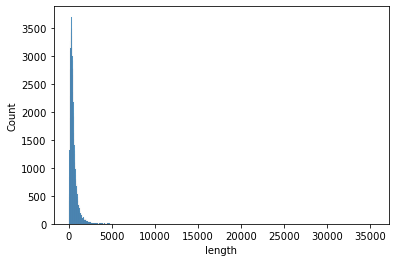

In [60]:
sb.histplot(sequence_info.length)

### Species info

In [109]:
counts = sequence_info["species"].value_counts()

In [110]:
counts

Homo sapiens                    25122
Arabidopsis thaliana            14461
Mus musculus                    14384
Danio rerio                     12671
Drosophila melanogaster         12020
                                ...  
Protobothrops mucrosquamatus        1
Chicken anemia virus                1
Thelephora ganbajun                 1
Dioscorea japonica                  1
Ficedula albicollis                 1
Name: species, Length: 2917, dtype: int64

Text(0.5, 1.0, 'Top 20 species CAFA 5 training set')

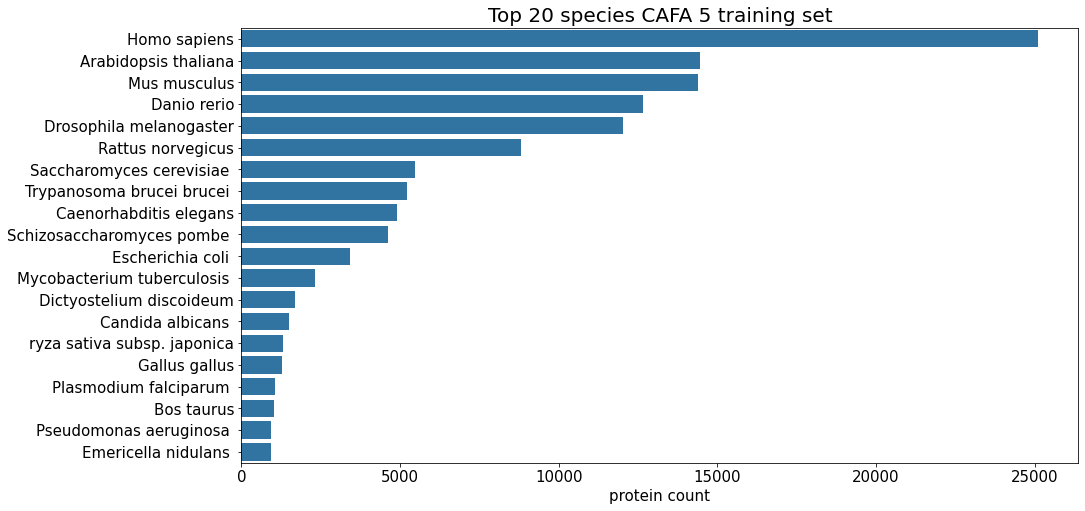

In [57]:
plt.figure(figsize=(15,8))
sb.barplot(counts[:20],orient="h")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("protein count",fontsize=15)
plt.title("Top 20 species CAFA 5 training set",fontsize=20)

### Protein evidence info

In [111]:
sequence_info["protein evidence"]

0         1
1         2
2         1
3         1
4         2
         ..
142241    4
142242    3
142243    3
142244    4
142245    3
Name: protein evidence, Length: 142246, dtype: object

In [112]:

# Assuming `sequence_info` is your DataFrame with a column named "protein evidence"

# Create a mapping dictionary for PE levels
pe_mapping = {
    "1": "Evidence at protein level",
    "2": "Evidence at transcript level",
    "3": "Inferred from homology",
    "4": "Predicted",
    "5": "Uncertain",
    "no PE info": "No PE info"  # Handle the no PE info case
}

# Apply the mapping to the "protein evidence" column
sequence_info["protein evidence descriptive"] = sequence_info["protein evidence"].map(pe_mapping)

# Check the counts of each descriptive category
result_counts = sequence_info["protein evidence descriptive"].value_counts()

# Display the result
print(result_counts)


Evidence at protein level       83614
Evidence at transcript level    24743
Inferred from homology          15206
Predicted                       15113
No PE info                       3405
Uncertain                         165
Name: protein evidence descriptive, dtype: int64


Text(0.5, 1.0, 'Evidence Levels for Training Data')

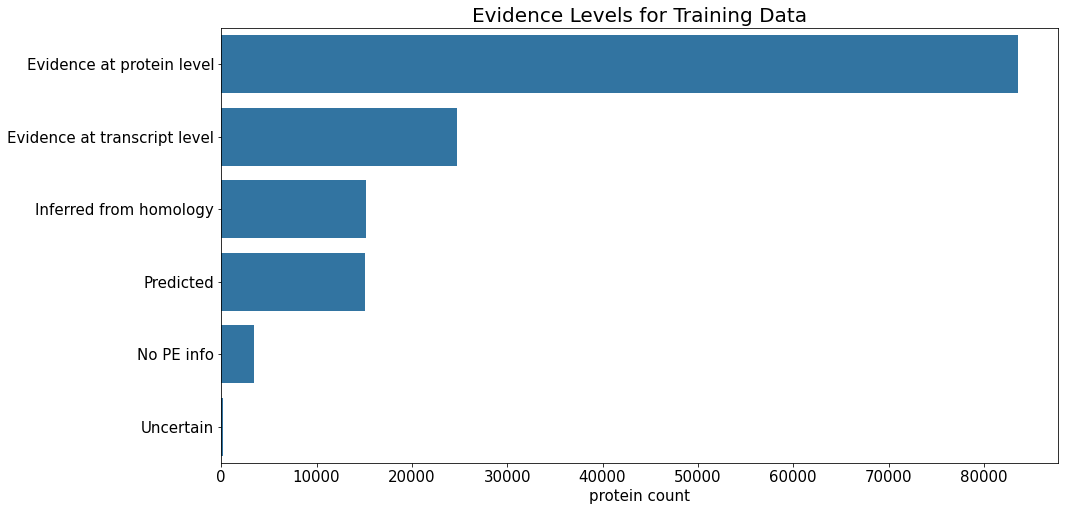

In [113]:
plt.figure(figsize=(15,8))
sb.barplot(sequence_info["protein evidence descriptive"].value_counts(),orient="h")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("protein count",fontsize=15)
plt.title("Evidence Levels for Training Data",fontsize=20)

## Huggingface Dataset

In [17]:
dataset = Dataset.from_dict({'identifier' : identifiers,
                        'sequence': seqs,
                        'species' : species})

In [18]:
dataset[0]

{'identifier': 'P20536',
 'sequence': 'MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLKQPLRNKRVCVCGIDPYPKDGTGVPFESPNFTKKSIKEIASSISRLTGVIDYKGYNLNIIDGVIPWNYYLSCKLGETKSHAIYWDKISKLLLQHITKHVSVLYCLGKTDFSNIRAKLESPVTTIVGYHPAARDRQFEKDRSFEIINVLLELDNKVPINWAQGFIY',
 'species': 'Vaccinia virus '}

In [20]:
train_valid_split = dataset.train_test_split(test_size=0.2, seed=42)

In [22]:
train_valid_split 

DatasetDict({
    train: Dataset({
        features: ['identifier', 'sequence', 'species'],
        num_rows: 113796
    })
    test: Dataset({
        features: ['identifier', 'sequence', 'species'],
        num_rows: 28450
    })
})

In [ ]:
dataset.save_to_disk("path/to/dataset_folder")